In [2]:
!pip install wfdb
import io
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
import urllib.request
import datetime
from collections import namedtuple


     |████████████████████████████████| 112kB 7.2MB/s 
     |████████████████████████████████| 6.6MB 8.8MB/s 
     |████████████████████████████████| 163kB 48.9MB/s 


In [2]:
from google.colab import files
uploaded = files.upload()

Saving df_TS_exists_withoutTEMP_hourlycounts_nw.csv to df_TS_exists_withoutTEMP_hourlycounts_nw (5).csv


In [3]:
df_housrly_csvdata = pd.read_csv(io.BytesIO(uploaded['df_TS_exists_withoutTEMP_hourlycounts_nw.csv']))
#df_housrly_csvdata = pd.read_excel('df_TS_exists_withoutTEMP_hourlycounts.xls',)
# Dataset is now stored in a Pandas Dataframe
print ('shape of original dataframe from XLS : ', df_housrly_csvdata.shape)
#print(df_housrly_csvdata)

total_onset_bet_intime_outtime = df_housrly_csvdata[(df_housrly_csvdata['sepsis_onsettime'] >= df_housrly_csvdata['intime']  )
& (df_housrly_csvdata['sepsis_onsettime'] <=  df_housrly_csvdata['outtime']  ) ].shape[0]
print('Total number of ICU stays out of 1655 and whose sepsis onset time is between ICU in time and out time: ', total_onset_bet_intime_outtime)
print('Total number of ICU stays out of 1655 and who suffer from sepsis: ', df_housrly_csvdata[df_housrly_csvdata['sepsis_onsettime'].notnull()].shape[0] ) 
print('Total number of ICU stays out of 1655 and who DO NOT suffer from sepsis: ', df_housrly_csvdata[df_housrly_csvdata['sepsis_onsettime'].isnull()].shape[0] ) 


df_first24_csvdata = df_housrly_csvdata[df_housrly_csvdata['first24'] == 1]
print('Total number of ICU stays that contain less than 20% mnissing values for first 24 hours after in time: ', df_first24_csvdata.shape[0])
print('Total number of ICU stays that contain less than 20% mnissing values for first 24 hours after in time and those suffering from sepsis: ', 
      df_first24_csvdata[df_first24_csvdata['sepsis_onsettime'].notnull()].shape[0])
print('Total number of ICU stays that contain less than 20% mnissing values for first 24 hours after in time and those NOT suffering from sepsis: ', 
      df_first24_csvdata[df_first24_csvdata['sepsis_onsettime'].isnull()].shape[0])

                      

shape of original dataframe from XLS :  (1655, 14)
Total number of ICU stays out of 1655 and whose sepsis onset time is between ICU in time and out time:  998
Total number of ICU stays out of 1655 and who suffer from sepsis:  998
Total number of ICU stays out of 1655 and who DO NOT suffer from sepsis:  657
Total number of ICU stays that contain less than 20% mnissing values for first 24 hours after in time:  404
Total number of ICU stays that contain less than 20% mnissing values for first 24 hours after in time and those suffering from sepsis:  223
Total number of ICU stays that contain less than 20% mnissing values for first 24 hours after in time and those NOT suffering from sepsis:  181


In [ ]:
df_ts_records_columns = ['SUBJECT_ID','ICUSTAY_ID','RECORD','TIME','HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP'] 
df_ts_records_all_patients_columns =  ['SUBJECT_ID','ICUSTAY_ID','RECORD','TIME','HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP'] 

df_ts_records_all_patients = pd.DataFrame(columns=df_ts_records_all_patients_columns)


for index, row in df_first24_csvdata.iterrows():
    print(row['subject_id']);
    try:
      df_ts_records.drop(df_ts_records.index,inplace=True)
    except:
      print('MAIN DF does not exits')

    df_ts_records = pd.DataFrame(columns=df_ts_records_columns);

    wdb_dir_path = 'mimic3wdb/matched/p'+ str(row['subject_id']).zfill(6)[:2] + '/p' + str(row['subject_id']).zfill(6) + '/';
    wdb_path_toAllRecords = 'https://archive.physionet.org/physiobank/database/'+ wdb_dir_path + 'RECORDS';
    wdb_records =  urllib.request.urlopen(wdb_path_toAllRecords);   
    count_overlap = 0; 
    for lines in wdb_records.readlines():
      record = lines.decode("utf-8"); 
      record = str(record).rstrip()
      #print (record[-1:])
      if record[-1:] == 'n':
        #print(record);
        #print (wdb_dir_path);
        consider_record =0 ;
        record = str(record).rstrip()

        try:
          signals =''
          fields = ''
          signals,fields = wfdb.rdsamp(record, pn_dir=wdb_dir_path) ; 
          list_sig_name = [item.upper().replace(' ','') for item in fields['sig_name']]
          sig_exist_1 = all(x in list_sig_name for x in ['HR', 'SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP']);  #%SpO2
          sig_exist_2 = all(x in list_sig_name for x in ['HR', '%SPO2','ABPSYS','ABPDIAS','ABPMEAN','RESP']); 
          if ((sig_exist_1 == True) or (sig_exist_2 == True)) :
            consider_record = 1
          else:
            consider_record = 0
          record_starttime = datetime.datetime.combine(fields['base_date'] ,fields['base_time'] ) ;
          if  '%.3f'%(fields['fs']) == '1.000' :
            record_endtime = record_starttime + datetime.timedelta(seconds= (fields['sig_len']-1)) ;
          elif '%.3f'%(fields['fs'])== '0.017' :
            record_endtime = record_starttime + datetime.timedelta(minutes = (fields['sig_len']-1)) ;
          else : 
            print('ERROR IN SAMPLING');
            print(record);
            print (wdb_dir_path);
          #Caculate if we have a recording for the time of icu stay
          Range = namedtuple('Range', ['start', 'end'])
          r1 = Range(start= datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S'), end= datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S'))
          r2 = Range(start= record_starttime, end = record_endtime)
          latest_start = max(r1.start, r2.start)
          earliest_end = min(r1.end, r2.end)
          delta = (earliest_end - latest_start).days + 1
          df_row_idx = df_ts_records.shape[0] ;
          if ((delta >= 0 ) & (consider_record ==1)) :
            ###
            try:
              df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True)
            except:
              print('individual record for a single patient df does not exists')
              
            df_ts_indv_record_temp = pd.DataFrame(columns = df_ts_records_columns ) # individual record for a single patient #safiya
            ###
            #print('RECORD EXISTS FOR THE ICU STAYS WITH THE SIGNALS NEEDED : ', row['subject_id'])
            #df_csvdata.loc[index,'timeoverlap'] = 1;
            #todo : adding new dataframe, exatracting required signals, computing avergage for per sminute values in case of per second sampling frequency
            for i in fields['sig_name']:
              if i.upper().replace(' ','') == 'HR':
                idx_HR='';
                idx_HR = fields['sig_name'].index(i);
              elif (( i.upper().replace(' ','') == 'SPO2') or (i.upper().replace(' ','') =='%SPO2')):
                idx_SPO2 = '';
                idx_SPO2 = fields['sig_name'].index(i);
              elif i.upper().replace(' ','') == 'ABPSYS' :
                idx_ABPSYS = '';
                idx_ABPSYS = fields['sig_name'].index(i);
              elif i.upper().replace(' ','') == 'ABPDIAS' :
                idx_ABPDIAS = '';
                idx_ABPDIAS = fields['sig_name'].index(i);
              elif i.upper().replace(' ','') == 'ABPMEAN' :
                idx_ABPMEAN = '';
                idx_ABPMEAN = fields['sig_name'].index(i);
              elif i.upper().replace(' ','') == 'RESP' :
                idx_RESP = '';
                idx_RESP = fields['sig_name'].index(i);
                
            if count_overlap == 0 : 
              if record_starttime > (datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') ):
                #print('inserting nulls between icu intime and record start time')
                minutes_to_insert_start = record_starttime - (datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') )
                #print('minutes_to_insert_start:  ', minutes_to_insert_start)
                duration_in_s = minutes_to_insert_start.total_seconds()
                minutes_to_insert_start = divmod(duration_in_s, 60)[0] - 1 
                try:
                  df_ts_records_time_temp_start.drop(df_ts_records_time_temp_start.index,  inplace=True)
                except :
                  print( 'df_ts_records_time_temp_start does not exist')
                df_ts_records_time_temp_start = pd.DataFrame(columns=df_ts_records_columns)
                if '%.3f'%(fields['fs'])== '0.017' :
                  df_ts_records_time_temp_start['TIME'] = pd.date_range((datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') ) + datetime.timedelta(minutes=1), 
                                                              periods = minutes_to_insert_start, freq='1min'); 
                elif '%.3f'%(fields['fs'])== '1.000' :
                  df_ts_records_time_temp_start['TIME'] = pd.date_range((datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') ) + datetime.timedelta(seconds=1), 
                                                              periods = (duration_in_s-1), freq='S');  
                df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_time_temp_start, ignore_index=True);

              try:
                df_ts_records_temp.drop(df_ts_records_temp.index,  inplace=True)
              except:
                print( 'df_ts_records_time_temp_start does not exist')
              df_ts_records_temp = pd.DataFrame(columns=df_ts_records_columns)
              df_ts_records_temp['HR']= signals[:,idx_HR ] 
              df_ts_records_temp['SPO2']= signals[:,idx_SPO2 ] 
              df_ts_records_temp['ABPSYS']= signals[:,idx_ABPSYS ] 
              df_ts_records_temp['ABPDIAS']= signals[:,idx_ABPDIAS ] 
              df_ts_records_temp['ABPMEAN']= signals[:,idx_ABPMEAN ] 
              df_ts_records_temp['RESP']= signals[:,idx_RESP ] 
              if '%.3f'%(fields['fs'])== '0.017' :
                df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='1min'); 
              elif '%.3f'%(fields['fs'])== '1.000' :
                df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='S'); 
              df_ts_records_temp.TIME = pd.to_datetime(df_ts_records_temp.TIME)
              df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_temp, ignore_index=True);
              df_ts_indv_record_temp['RECORD'] = record;

              if '%.3f'%(fields['fs'])== '1.000' : #safiya
                #print('shape of persecond data before aggregation: ', df_ts_indv_record_temp.shape)
                #print('aggregating first record')
                start_idx = 0;
                try:
                  df_ts_records_new.drop(df_ts_records_new.index, inplace=True)
                except:
                  print('df_ts_records_new does not exists')
                df_ts_records_new = pd.DataFrame(columns=df_ts_records_columns);
                #print('length of new df  '  , df_ts_records_new.shape[0] )
                for index, rows in df_ts_indv_record_temp.iterrows():
                  if start_idx >= df_ts_indv_record_temp.shape[0]:
                    exit;
                  else: 
                    #print(df_ts_records.iloc[start_idx: (start_idx+60), 2:8])
                    array = np.array( df_ts_indv_record_temp.iloc[start_idx: (start_idx+60), 4:10].mean(axis=0))
                    current_index = df_ts_records_new.shape[0]
                    df_ts_records_new.loc[current_index ,'HR']= array[0]
                    df_ts_records_new.loc[current_index,'SPO2']= array[1]
                    df_ts_records_new.loc[current_index,'ABPSYS']= array[2]
                    df_ts_records_new.loc[current_index,'ABPDIAS']= array[3]
                    df_ts_records_new.loc[current_index,'ABPMEAN']= array[4]
                    df_ts_records_new.loc[current_index,'RESP']= array[5]
                    start_idx = start_idx+60;

                #print('finished aggregating first record and now inserting into main df for a patient')
                df_ts_records_new['TIME'] = pd.date_range(df_ts_indv_record_temp.loc[0,'TIME'], periods= df_ts_records_new.shape[0], freq='1min'); 
                df_ts_records_new.TIME = pd.to_datetime(df_ts_records_new.TIME)
                df_ts_records_new['RECORD'] = record
                df_ts_records = df_ts_records.append(df_ts_records_new, ignore_index=True); # appending at one subject level
                df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True);
                df_ts_records_new.drop(df_ts_records_new.index, inplace=True)   
                #print('finished aggregating first record')

              else:
                df_ts_records = df_ts_records.append(df_ts_indv_record_temp, ignore_index=True);
                df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True);
                

            else: # when it is a second/ third/... record for one subject
              if record_starttime < (datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S') ) :
                last_Record_time = df_ts_records.loc[(df_row_idx-1),'TIME']
                #print('main DF last time record: ',last_Record_time )
                minutes_to_insert = record_starttime - last_Record_time
                duration_in_s = minutes_to_insert.total_seconds()
                minutes_to_insert = divmod(duration_in_s, 60)[0] - 1
                #print ('minutes_to_insert:  ', minutes_to_insert);
                try:
                  df_ts_records_time_temp.drop(df_ts_records_time_temp.index, inplace= True);
                  df_ts_records_temp.drop(df_ts_records_temp.index, inplace=True);
                except:
                  print ('df_ts_records_temp and df_ts_records_time_temp does not exits')
                df_ts_records_time_temp = pd.DataFrame(columns=df_ts_records_columns)
                if '%.3f'%(fields['fs'])== '0.017' :
                  df_ts_records_time_temp['TIME'] = pd.date_range(last_Record_time + datetime.timedelta(minutes=1), 
                                                              periods=minutes_to_insert, freq='1min'); 
                elif '%.3f'%(fields['fs'])== '1.000' :
                  df_ts_records_time_temp['TIME'] = pd.date_range(last_Record_time + datetime.timedelta(seconds=1), 
                                                              periods=(duration_in_s-1), freq='S'); 
                #print ('df_ts_records_time_temp:')
                #print (df_ts_records_time_temp)
                df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_time_temp, ignore_index=True);
              
                df_ts_records_temp = pd.DataFrame(columns=df_ts_records_columns)
                df_ts_records_temp['HR']= signals[:,idx_HR ] 
                df_ts_records_temp['SPO2']= signals[:,idx_SPO2 ] 
                df_ts_records_temp['ABPSYS']= signals[:,idx_ABPSYS ] 
                df_ts_records_temp['ABPDIAS']= signals[:,idx_ABPDIAS ] 
                df_ts_records_temp['ABPMEAN']= signals[:,idx_ABPMEAN ] 
                df_ts_records_temp['RESP']= signals[:,idx_RESP ] 
                if '%.3f'%(fields['fs'])== '0.017' :
                  df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='1min'); 
                elif  '%.3f'%(fields['fs'])== '1.000' :
                  df_ts_records_temp['TIME'] = pd.date_range(record_starttime, periods=fields['sig_len'], freq='S'); 
                df_ts_records_temp.TIME = pd.to_datetime(df_ts_records_temp.TIME)
                df_ts_indv_record_temp = df_ts_indv_record_temp.append(df_ts_records_temp, ignore_index=True);
                df_ts_indv_record_temp['RECORD'] = record;
                
                if '%.3f'%(fields['fs'])== '1.000' : #safiya
                  #print('aggregating second record')
                  start_idx = 0;
                  try:
                    df_ts_records_new.drop(df_ts_records_new.index, inplace=True)
                  except:
                    print('df_ts_records_new does not exists')
                  df_ts_records_new = pd.DataFrame(columns=df_ts_records_columns);
                  #print('length of new df  '  , df_ts_records_new.shape[0] )
                  for index, rows in df_ts_indv_record_temp.iterrows():
                    if start_idx >= df_ts_indv_record_temp.shape[0]:
                      exit;
                    else: 
                      array = np.array( df_ts_indv_record_temp.iloc[start_idx: (start_idx+60), 4:10].mean(axis=0))
                      current_index = df_ts_records_new.shape[0]
                      df_ts_records_new.loc[current_index ,'HR']= array[0]
                      df_ts_records_new.loc[current_index,'SPO2']= array[1]
                      df_ts_records_new.loc[current_index,'ABPSYS']= array[2]
                      df_ts_records_new.loc[current_index,'ABPDIAS']= array[3]
                      df_ts_records_new.loc[current_index,'ABPMEAN']= array[4]
                      df_ts_records_new.loc[current_index,'RESP']= array[5]
                      start_idx = start_idx+60;
                  
                  #print('finished aggregating second record and now inserting into main df for a patient')
                  df_ts_records_new['TIME'] = pd.date_range(df_ts_indv_record_temp.loc[0,'TIME'], periods= df_ts_records_new.shape[0], freq='1min'); 
                  df_ts_records_new.TIME = pd.to_datetime(df_ts_records_new.TIME)
                  df_ts_records_new['RECORD'] = record;
                  #df_ts_records = pd.DataFrame(columns=df_ts_records_columns)
                  df_ts_records = df_ts_records.append(df_ts_records_new, ignore_index=True);
                  df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True);
                  df_ts_records_new.drop(df_ts_records_new.index, inplace=True)
                  #print('finished aggregating second record')

                else:
                  df_ts_records = df_ts_records.append(df_ts_indv_record_temp, ignore_index=True);
                  df_ts_indv_record_temp.drop(df_ts_indv_record_temp.index, inplace=True);
                     

            
            #FS = '%.3f'%(fields['fs'])
            #print(FS)
            count_overlap = count_overlap +1
          else:            
            print('RECORD DOES NOT EXISTS FOR THE ICU STAYS WITH THE SIGNALS NEEDED : ', row['subject_id'])
              #df_csvdata.loc[index,'timeoverlap'] = 0;

        except ValueError:
          print('Error occured while reading waveform: ', record);


    #print((datetime.datetime.strptime(row['intime'],'%Y-%m-%d %H:%M:%S') ) + datetime.timedelta(hours=24))
    try:
      last_record_idx = df_ts_records.shape[0] - 1
      all_records_end_time = df_ts_records.loc[last_record_idx,'TIME']
      
      if (all_records_end_time < (datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S') ) ):
        #print('INSERTING NULLS AT THE END')
        try:
          df_ts_records_time_temp_end.drop(df_ts_records_time_temp_end.index, inplace=True)
        except:
          print('df_ts_records_time_temp_end does not exists')
        #print('main DF last time record: ',last_Record_time )
        minutes_to_insert_end = (datetime.datetime.strptime(row['outtime'],'%Y-%m-%d %H:%M:%S') ) - all_records_end_time
        duration_in_s = minutes_to_insert_end.total_seconds()
        minutes_to_insert_end = divmod(duration_in_s, 60)[0] - 1
        df_ts_records_time_temp_end = pd.DataFrame(columns=df_ts_records_columns)
        
        df_ts_records_time_temp_end['TIME'] = pd.date_range(all_records_end_time + datetime.timedelta(minutes=1), 
                                                              periods=minutes_to_insert_end, freq='1min'); 
        df_ts_records = df_ts_records.append(df_ts_records_time_temp_end, ignore_index=True);
        #print('appended to df_ts_records')
      
      #df_ts_records['RECORD'] = record
      df_ts_records['SUBJECT_ID'] = row['subject_id']
      df_ts_records['ICUSTAY_ID'] = row['icustay_id']
      #print(df_ts_records)

      df_ts_records_all_patients = df_ts_records_all_patients.append(df_ts_records, ignore_index=True);
      print('successfully inserted: ',row['subject_id'])
      #print(df_ts_records_all_patients)
      
    except:
      print('Error occured while reading waveform for patient: ', row['subject_id'])

In [6]:
print(df_ts_records_all_patients.shape)

(2530520, 10)


In [7]:
df_ts_records_all_patients.to_csv ('df_ts_records_all404_patients.csv', sep=',', index = False, header=True);


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
!cp "/content/df_ts_records_all404_patients.csv" "/content/gdrive/My Drive/Master thesis"


In [4]:
df_all404_csvdata = pd.read_csv('/content/gdrive/My Drive/Master thesis/df_ts_records_all404_patients.csv')
print(df_all404_csvdata.shape)

(2530520, 10)


Statistics=30616.495, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: -0.022629796677320346
Skewness of normal distribution: 0.30884907680638135


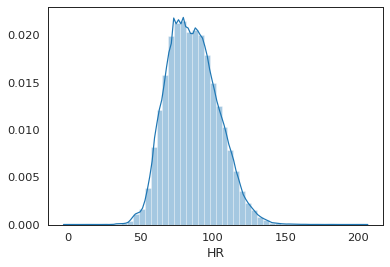

In [6]:
from scipy import stats
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
#print(df_all394_csvdata)

df_all404_csvdata_HR = df_all404_csvdata.dropna(subset=['HR']) 


stat, p = stats.normaltest(df_all404_csvdata_HR.HR)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

sns.distplot(df_all404_csvdata_HR.HR);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df_all404_csvdata_HR.HR)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df_all404_csvdata_HR.HR)))

Statistics=80955.293, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 1.5652175391650696
Skewness of normal distribution: 0.18962415420274034


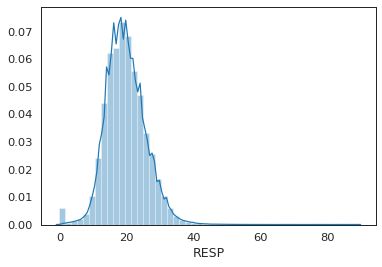

In [7]:

df_all404_csvdata_RESP = df_all404_csvdata.dropna(subset=['RESP']) 


stat, p = stats.normaltest(df_all404_csvdata_RESP.RESP)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

sns.distplot(df_all404_csvdata_RESP.RESP);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df_all404_csvdata_RESP.RESP)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df_all404_csvdata_RESP.RESP)))



Statistics=11626557.603, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 1495582.0000004666
Skewness of normal distribution: -1222.9407181054835


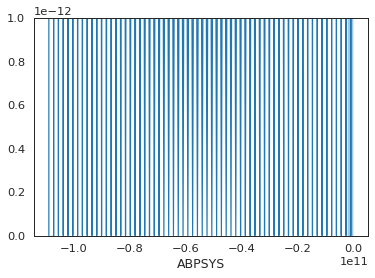

In [8]:
from scipy import stats
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
df_all404_csvdata_ABPSYS = df_all404_csvdata.dropna(subset=['ABPSYS']) 


stat, p = stats.normaltest(df_all404_csvdata_ABPSYS.ABPSYS)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

sns.distplot(df_all404_csvdata_ABPSYS.ABPSYS);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df_all404_csvdata_ABPSYS.ABPSYS)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df_all404_csvdata_ABPSYS.ABPSYS)))



Statistics=731286.693, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 16.452351650081457
Skewness of normal distribution: 1.8310448760306448


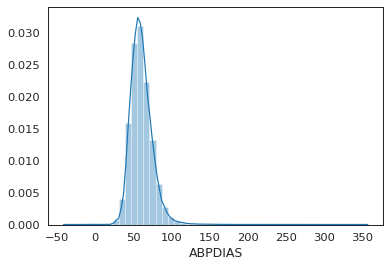

In [9]:

df_all404_csvdata_ABPDIAS = df_all404_csvdata.dropna(subset=['ABPDIAS']) 


stat, p = stats.normaltest(df_all404_csvdata_ABPDIAS.ABPDIAS)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

sns.distplot(df_all404_csvdata_ABPDIAS.ABPDIAS);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df_all404_csvdata_ABPDIAS.ABPDIAS)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df_all404_csvdata_ABPDIAS.ABPDIAS)))

Statistics=11796924.034, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 1515223.6888209821
Skewness of normal distribution: -1230.9449757120165


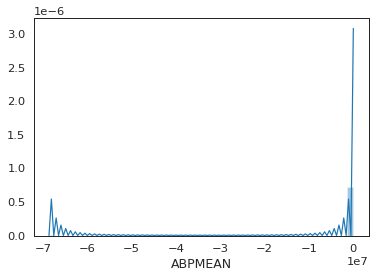

In [10]:

df_all404_csvdata_ABPMEAN = df_all404_csvdata.dropna(subset=['ABPMEAN']) 

stat, p = stats.normaltest(df_all404_csvdata_ABPMEAN.ABPMEAN)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

sns.distplot(df_all404_csvdata_ABPMEAN.ABPMEAN);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df_all404_csvdata_ABPMEAN.ABPMEAN)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df_all404_csvdata_ABPMEAN.ABPMEAN)))

Statistics=1802792.145, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 48.27112488869481
Skewness of normal distribution: -4.051964088239868


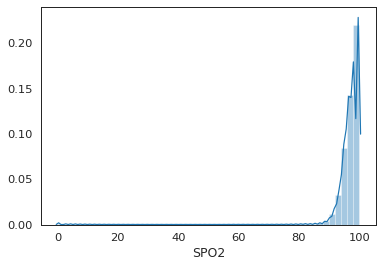

In [11]:

df_all404_csvdata_SPO2 = df_all404_csvdata.dropna(subset=['SPO2']) 

stat, p = stats.normaltest(df_all404_csvdata_SPO2.SPO2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
   print('Data looks Gaussian (fail to reject H0)')
else:
   print('Data does not look Gaussian (reject H0)')

sns.distplot(df_all404_csvdata_SPO2.SPO2);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis
                                                      (df_all404_csvdata_SPO2.SPO2)))
print('Skewness of normal distribution: {}'.format(stats.skew
                                                      (df_all404_csvdata_SPO2.SPO2)))

In [12]:
"""
pd.set_option('display.max_rows', 500000)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 10000)
"""
df = df_all404_csvdata[df_all404_csvdata['SUBJECT_ID']==95118]
print(df)

         SUBJECT_ID  ICUSTAY_ID  ... ABPMEAN       RESP
2528816       95118      232418  ...     NaN   7.833333
2528817       95118      232418  ...     NaN  10.866667
2528818       95118      232418  ...     NaN  12.062500
2528819       95118      232418  ...     NaN   7.316667
2528820       95118      232418  ...     NaN  10.333333
...             ...         ...  ...     ...        ...
2530515       95118      232418  ...     NaN        NaN
2530516       95118      232418  ...     NaN        NaN
2530517       95118      232418  ...     NaN        NaN
2530518       95118      232418  ...     NaN        NaN
2530519       95118      232418  ...     NaN        NaN

[1704 rows x 10 columns]
